# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Introduction: Business Problem

The aim for this final project is to explores the best locations for indian restaurants throughout the city of New York. New York is a major metropolitan area with more than 8.4 million (Quick Facts, 2018) people living within city limits. Being the largest ethnic indian population outside of Asia, the need to find and enjoy chinese cuisine is on the rise. This report explores which neighborhoods and boroughs of New York City have the most as well as the best chinese restaurants. So as part of this project , we will list and visualize all major parts of New York City that has great indian resturants.

## Data

In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of indian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

## Approach

1. Collect the new york city data from https://cocl.us/new_york_dataset
2. Using FourSquare API we will find all venues for each neighborhood.
3. Filter out all venues that are Indian Resturants.
4. Find rating , tips and like count for each Indian Resturants using FourSquare API.
5. Using rating for each resturant , we will sort that data.
6. Visualize the Ranking of neighborhoods using folium library(python)

## Questions that can be answered using dataset above

1. What is best location in New York City for Indian Cuisine ?
2. Which areas have potential Indian Resturant Market ?
3. Which all areas lack Indian Resturants ?
4. Which is the best place to stay if I prefer Indian Cuisine ?

In [49]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [14]:
CLIENT_ID = '3SRO4J1L50RY5XRWDCFLDR0YWAO1SXSMXRHUYQRXQWSKC4J0' # your Foursquare ID
CLIENT_SECRET = 'YDGUOCQW3WZPSY3ZJHNKWKN02JHP3XCCBHKGUOG1VTVCG3GL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

In [13]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:

def get_venue_details(venue_id):
        
    CLIENT_ID = '3SRO4J1L50RY5XRWDCFLDR0YWAO1SXSMXRHUYQRXQWSKC4J0' # i have changed the id with ##
    CLIENT_SECRET = 'YDGUOCQW3WZPSY3ZJHNKWKN02JHP3XCCBHKGUOG1VTVCG3GL' # i have changed the secret with ##
    VERSION = '20180604' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [11]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
new_york_data.shape

(306, 4)

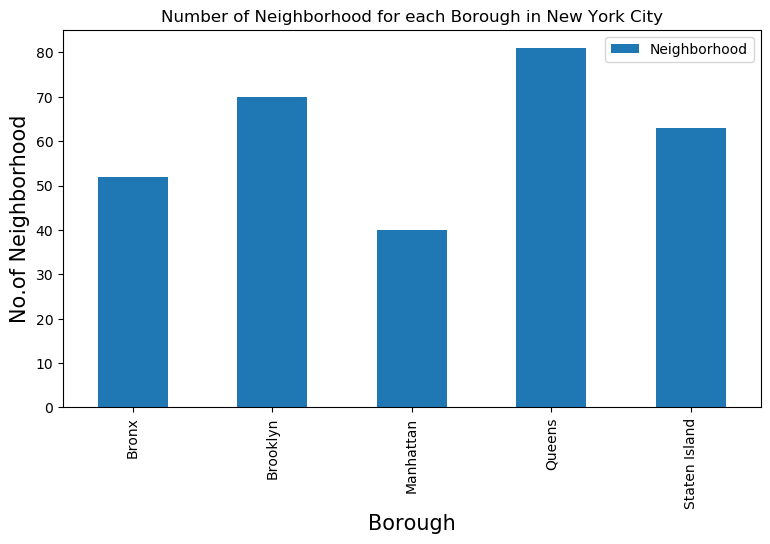

In [8]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [15]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [16]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,55dfa36a498e164ef19bef7b,Premium Sweets & Restaurant
2,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill
3,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill
4,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal


In [17]:
indian_rest_ny.shape

(37, 4)

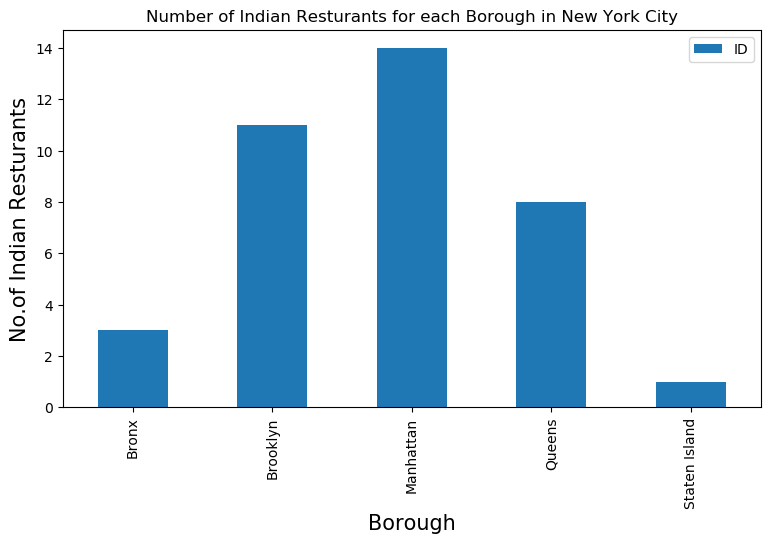

In [18]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

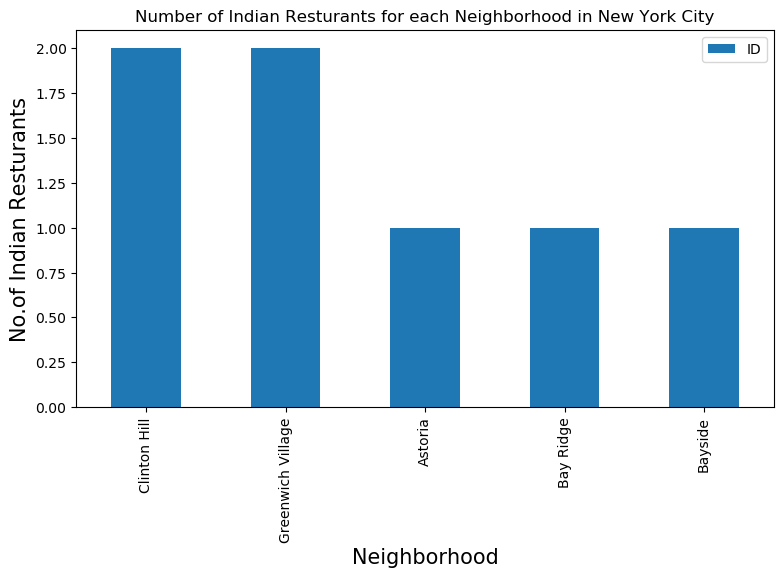

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [21]:
indian_rest_ny[indian_rest_ny['Borough']=='Manhattan']

,Borough,Neighborhood,ID,Name
14,Manhattan,Washington Heights,4ae7876ef964a5201eac21e3,Kismat Indian Restaurant
15,Manhattan,Hamilton Heights,54c2bd96498eaf5142e3fe92,Clove Indian Restaurant & Bar
16,Manhattan,Manhattanville,529d382a11d2dd5ef107e641,Chapati House - NYC
17,Manhattan,Yorkville,4e221f671495f18f035610f6,Mumtaz
18,Manhattan,Midtown,5953e40462420b044e8989f4,indikitch
19,Manhattan,Chelsea,4b4aab62f964a520978c26e3,Dil-e Punjab Deli
20,Manhattan,Greenwich Village,56c931b2cd10407d3ecbefda,Ananda
21,Manhattan,Greenwich Village,4593ed04f964a52050401fe3,The Kati Roll Company
22,Manhattan,Tribeca,4bbb9dbded7776b0e1ad3e51,Tamarind TriBeCa
23,Manhattan,West Village,5803c0db38fa71491b748a7d,Taco Mahal


In [22]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     8.1    10
( 1 / 37 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 2 / 37 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.9     2
( 3 / 37 ) processed
                         ID          Name  Likes  Rating  Tips
0  545835a1498e820edc6f636f  Bombay Grill     14     7.1     4
( 4 / 37 ) processed
                         ID            Name  Likes  Rating  Tips
0  51a5445c498ee0f182370cb2  Agra Taj Mahal     34     7.2    16
( 5 / 37 ) processed
                         ID          Name  Likes  Rating  Tips
0  5169f5c4e4b0c7fcb77a0f3c  Agra Heights     12     5.6     5
( 6 / 37 ) processed
                         ID           Name  Likes  Rating  Tips
0  4b8ffc16f964a520246e33e3  Cur

In [23]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.1,10
1,Bronx,Parkchester,0,0,0,0.0,0
2,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2
3,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill,14,7.1,4
4,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal,34,7.2,16


In [24]:
indian_rest_stats_ny.shape

(37, 7)

In [26]:
indian_rest_ny.shape

(37, 4)

In [27]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [28]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [29]:
indian_rest_stats_ny_csv.shape

(37, 7)

In [30]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.1,10
1,Bronx,Parkchester,0,0,0,0.0,0
2,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.9,2
3,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill,14,7.1,4
4,Brooklyn,Greenpoint,51a5445c498ee0f182370cb2,Agra Taj Mahal,34,7.2,16


In [31]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       37 non-null     object 
 1   Neighborhood  37 non-null     object 
 2   ID            37 non-null     object 
 3   Name          37 non-null     object 
 4   Likes         37 non-null     object 
 5   Rating        37 non-null     float64
 6   Tips          37 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.1+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [32]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       37 non-null     object 
 1   Neighborhood  37 non-null     object 
 2   ID            37 non-null     object 
 3   Name          37 non-null     object 
 4   Likes         37 non-null     float64
 5   Rating        37 non-null     float64
 6   Tips          37 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.1+ KB


In [35]:
# Restaurant with maximum like
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                                 9
Tips                                 148
Name: 22, dtype: object

In [34]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                                 9
Tips                                 148
Name: 22, dtype: object

In [36]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                                 9
Tips                                 148
Name: 22, dtype: object

In [37]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [38]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(30)

,Neighborhood,Average Rating
28,Tribeca,9.00
10,Fort Greene,8.80
21,Noho,8.70
7,Chelsea,8.70
24,Prospect Lefferts Gardens,8.70
31,West Village,8.60
13,Greenwich Village,8.60
2,Bayside,8.30
27,Sutton Place,8.30
0,Astoria,8.20


Above are the top neighborhoods with top average rating of Indian resturant

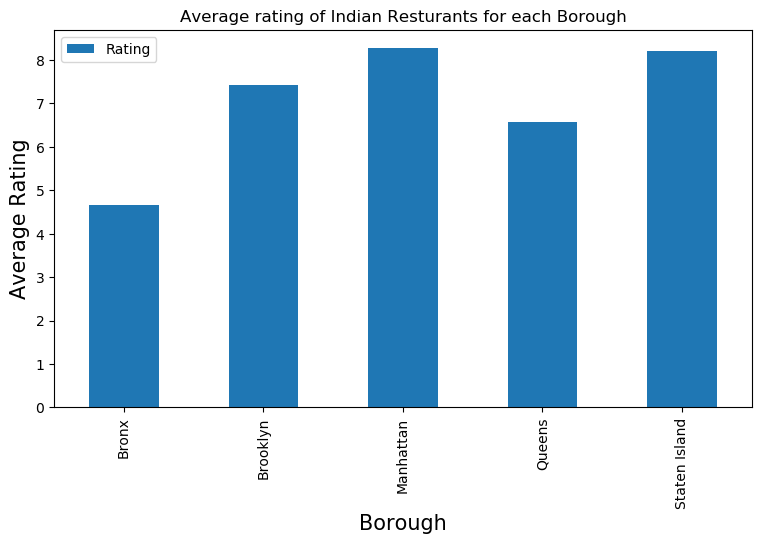

In [39]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [40]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
28,Tribeca,9.0


In [41]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [42]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Tribeca,40.721522,-74.010683,9.0


Let's create a map to show the data

In [43]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [44]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [45]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [46]:

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [53]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

FileNotFoundError: [Errno 2] No such file or directory: 'Borough Boundaries.geojson'